In [2]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=4752637a6d814916c075e9c14502f1cb542b74726b688722ecedc30df5ee1575
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
from pyspark.sql.functions import split, explode, avg
import matplotlib.pyplot as plt

In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MovieRecommendation").getOrCreate()

ratings_data = spark.read.csv("data/rating.csv", header=True, inferSchema=True)
movies_data = spark.read.csv("data/movie.csv", header=True, inferSchema=True)
tags_data = spark.read.csv("data/tag.csv", header=True, inferSchema=True)

In [12]:
# Split genres into individual genre columns
genres_data = movies_data.withColumn("genre", explode(split(movies_data["genres"], "\\|")))

# Count the occurrences of each genre
genre_counts = genres_data.groupBy("genre").count().orderBy("count", ascending=False)

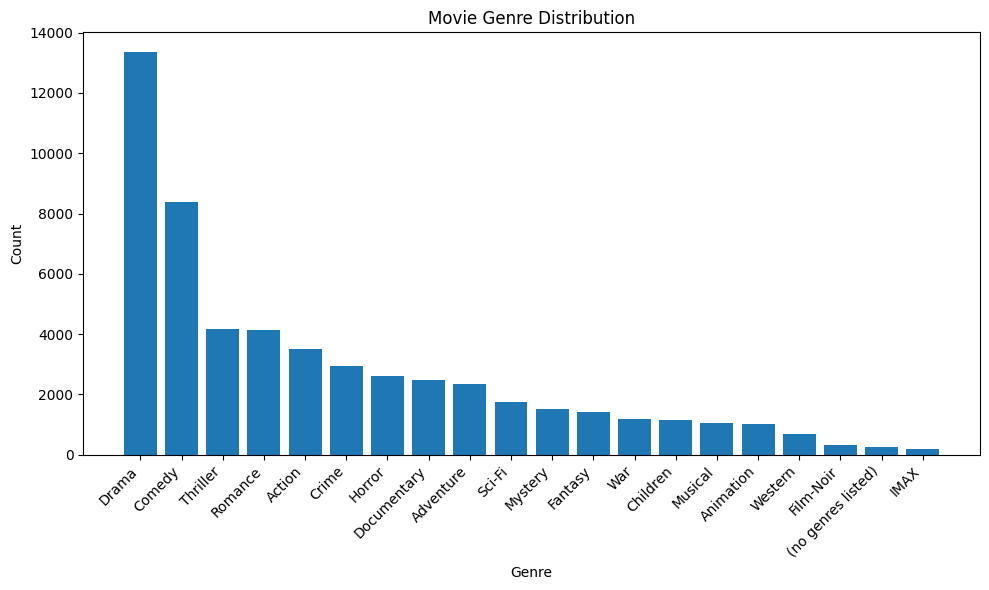

In [13]:
# Convert genre counts DataFrame to Pandas
genre_counts_pd = genre_counts.toPandas()

# Create a bar plot for genre distribution
plt.figure(figsize=(10, 6))
plt.bar(genre_counts_pd["genre"], genre_counts_pd["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Movie Genre Distribution")
plt.tight_layout()
plt.show()

In [15]:
# Join ratings data with movies data to get movie ratings and genres
movies_with_ratings = movies_data.join(ratings_data, on="movieId", how="inner")

# Calculate average ratings for each genre
avg_ratings_by_genre = movies_with_ratings.groupBy("genres").avg("rating").orderBy("avg(rating)", ascending=False)

In [16]:
# Group tags by their occurrences
tag_counts = tags_data.groupBy("tag").count().orderBy("count", ascending=False)

In [18]:
# Load genome scores data
genome_scores_data = spark.read.csv("data/genome_scores.csv", header=True, inferSchema=True)

# Calculate average relevance for each tag
avg_relevance_by_tag = genome_scores_data.groupBy("tagId").avg("relevance")

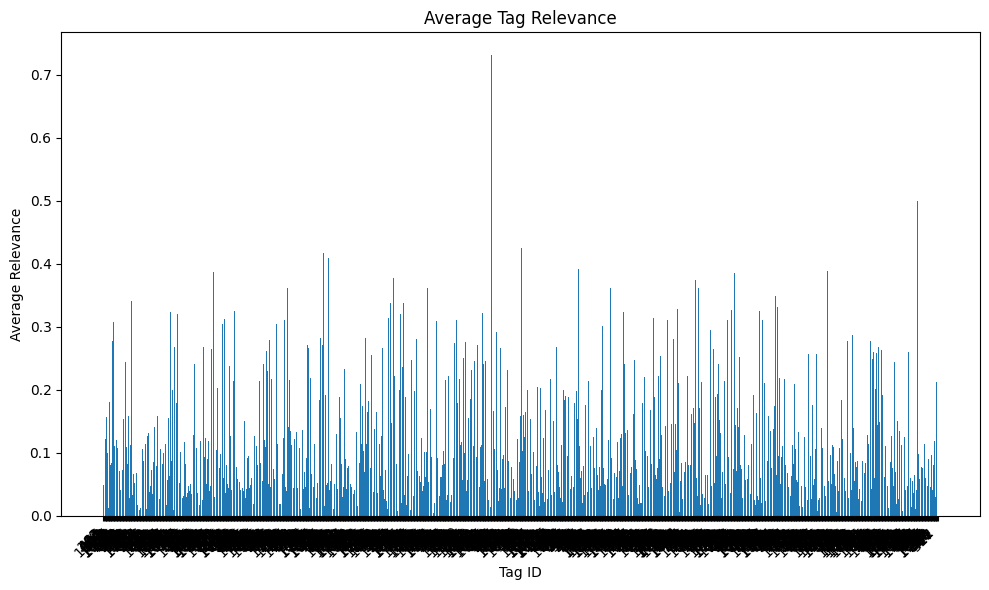

In [19]:
# Convert tag relevance DataFrame to Pandas
avg_relevance_by_tag_pd = avg_relevance_by_tag.toPandas()

# Create a bar plot for tag relevance
plt.figure(figsize=(10, 6))
plt.bar(avg_relevance_by_tag_pd.index, avg_relevance_by_tag_pd["avg(relevance)"])
plt.xticks(avg_relevance_by_tag_pd.index, avg_relevance_by_tag_pd["tagId"], rotation=45, ha="right")
plt.xlabel("Tag ID")
plt.ylabel("Average Relevance")
plt.title("Average Tag Relevance")
plt.tight_layout()
plt.show()

In [22]:
# Join movies with ratings data
movies_with_ratings = movies_data.join(ratings_data, on="movieId", how="inner")

# Join movies_with_ratings with genome scores data to get tag relevance
movies_with_relevance = movies_with_ratings.join(genome_scores_data, on="movieId", how="inner")

In [24]:
# Calculate average ratings and tag relevance for each genre
genre_popularity = movies_with_relevance.groupBy("genres").agg(
    avg("rating").alias("avg_rating"),
    avg("relevance").alias("avg_relevance")
).orderBy("avg_rating", ascending=False)

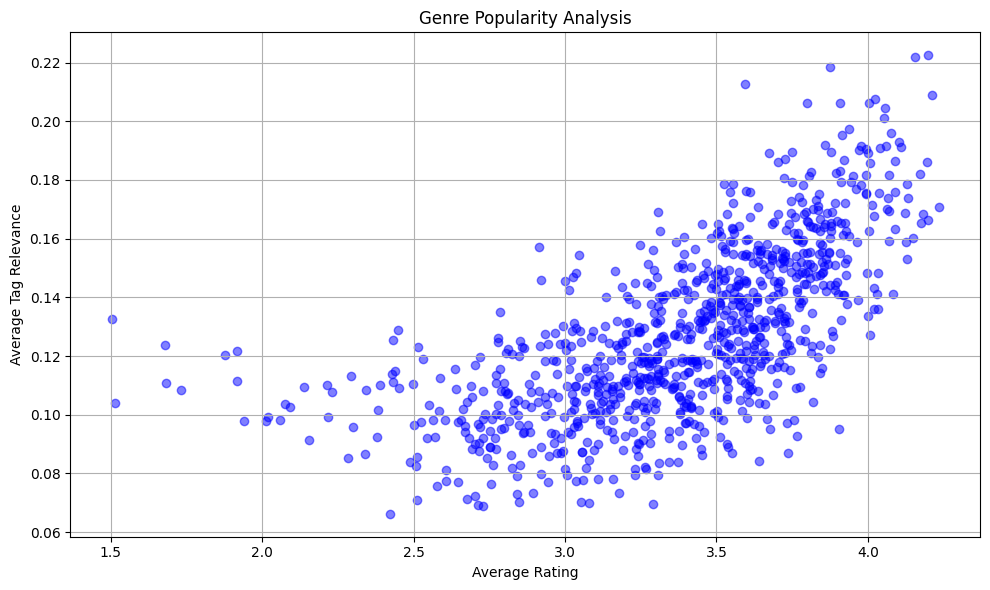

In [25]:
import matplotlib.pyplot as plt

# Convert genre popularity DataFrame to Pandas
genre_popularity_pd = genre_popularity.toPandas()

# Create a scatter plot to show genre popularity
plt.figure(figsize=(10, 6))
plt.scatter(genre_popularity_pd["avg_rating"], genre_popularity_pd["avg_relevance"], color="blue", alpha=0.5)
plt.xlabel("Average Rating")
plt.ylabel("Average Tag Relevance")
plt.title("Genre Popularity Analysis")
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Filter genres with high average rating and high average tag relevance
popular_genres = genre_popularity.filter((genre_popularity.avg_rating >= 3.5) & (genre_popularity.avg_relevance >= 0.14))
popular_genres.show()


+--------------------+------------------+-------------------+
|              genres|        avg_rating|      avg_relevance|
+--------------------+------------------+-------------------+
|Action|Adventure|...| 4.233538107122288|0.17096165780408035|
|Action|Crime|Dram...| 4.212306121456702|0.20883028248077737|
|Action|Adventure|...| 4.199872668713954|0.22250229901508256|
|Film-Noir|Romance...|   4.1977899432279|0.16648781028355433|
|Adventure|Animati...| 4.194087403598972| 0.1861346989309313|
|   Film-Noir|Mystery| 4.181754931652615|0.16845650596827216|
|Crime|Film-Noir|M...| 4.176315789473684|0.16519614258597196|
|Action|Adventure|...| 4.173373902938748| 0.1820049091597251|
|Action|Crime|Dram...| 4.156172003137702|0.22183266844115163|
|Animation|Childre...|4.1494807797413005| 0.1602535460990593|
|Crime|Film-Noir|T...| 4.133464884743026|0.17392190949944306|
|  Comedy|Musical|War| 4.129646256060334| 0.1531438386521248|
|  Crime|Thriller|War| 4.128504672897196|0.17878656914821514|
|Animati